## Bloom segments (Chlorophyll-A) from Sentinel-3 for Lake Erie

Sentinel-3 collects reflectance data of land/waterbodies. There are about 10 different wavelengths that are monitored by the S3 sensors. Based on these data, there is a derived metric Cholorophyll-A, that is published in the Level2 dataset. The chlorphyll-A is a leading or coincident indicator of phytoplankton activity. Tracking its growth/shrinkage is essential to determining Algal activity (toxic or otherwise)

In [1]:
import os
import numpy as np
import xarray as xr
import earthaccess
from datetime import datetime, timedelta
import pickle
import time
import random
from tqdm import tqdm

# Authenticate
auth = earthaccess.login(persist=True)


In [2]:
# Parameters
bbox = (-83.62, 41.34, -82, 42.27)      # (lon_min, lat_min, lon_max, lat_max)
res = 0.01
start_date = datetime(2024, 7, 21)
end_date = datetime(2024, 7, 21)
window_size = 7
decay = 0.8

# Ensure data directories exist
os.makedirs("../Data/", exist_ok=True)
os.makedirs("../Cache/", exist_ok=True)
os.makedirs("../Images/", exist_ok=True)

# Output grid
lat_bins = np.arange(bbox[1], bbox[3] + res, res)
lon_bins = np.arange(bbox[0], bbox[2] + res, res)
lat_centers = 0.5 * (lat_bins[:-1] + lat_bins[1:])
lon_centers = 0.5 * (lon_bins[:-1] + lon_bins[1:])
nlat, nlon = len(lat_centers), len(lon_centers)

mdata_file = "../Images/composite_metadata_S3.pkl"
npy_file = "../Images/composite_data_S3.npy"

In [3]:

# --- Retry Helpers ---
def safe_search(short_name, temporal, bounding_box, max_retries=500):
    retries = 0
    while True:
        try:
            results = earthaccess.search_data(
                short_name=short_name,
                temporal=temporal,
                bounding_box=bounding_box
            )
            return results
        except Exception as e:
            retries += 1
            if retries >= max_retries:
                print(f"Search failed after {max_retries} retries: {e}")
                return []
            wait = 5 + random.uniform(0, 3)
            print(f"Search error: {e}. Retrying in {wait:.1f} seconds...")
            time.sleep(wait)

def safe_download(results, directory="../Data/", max_retries=5):
    retries = 0
    while True:
        try:
            paths = earthaccess.download(results, directory)
            return paths
        except Exception as e:
            retries += 1
            if retries >= max_retries:
                print(f"Download failed after {max_retries} retries: {e}")
                return []
            wait = 5 + random.uniform(0, 3)
            print(f"Download error: {e}. Retrying in {wait:.1f} seconds...")
            time.sleep(wait)
            
# Wavelengths from a reference file (S3A or S3B, any available date)
def get_reference_wavelengths():
    satellites = ["OLCIS3A_L2_EFR_OC", "OLCIS3B_L2_EFR_OC"]
    ref_file = None
    #search_dates = [("2024-06-01", "2024-06-05"), ("2024-05-01", "2024-06-01"), ("2024-04-01", "2024-05-01")]
    search_dates = [("2024-06-01", "2024-06-05")]

    
    for sat in satellites:
        for temporal in search_dates:
            print(f"Trying to find wavelengths in {sat} from {temporal}...")

            search_ref = safe_search(
                short_name=sat,
                temporal=temporal,
                bounding_box=bbox,
            )
            if search_ref:
                ref_file = safe_download(search_ref, "../Data/")[0]
                try:
                    with xr.open_dataset(ref_file, group="sensor_band_parameters") as ds:
                        if "wavelength" in ds:
                            print("found wavelength")
                            wave_all = ds["wavelength"].data
                        elif "wavelength_3d" in ds:
                            print("found wavelength_3d")
                            wave_all = ds["wavelength_3d"].data
                        else:
                            raise KeyError("No 'wavelength' variable found in reference file.")
                    print(f"Found wavelengths in {ref_file} ({len(wave_all)} channels)")
                    return wave_all
                except Exception as e:
                    print(f"Failed to extract wavelengths from {ref_file}: {e}")
    raise RuntimeError("No reference files found to retrieve wavelengths.")


## Data Gathering
This algo works to gather granules that are relevant to the time window (+-7 days) relative to a anchor date. The granules carry both reflectance data as well as chlorophyll_a data. 

The reflectance data for all wavelengths and Chla data are spatially and time averaged (wihin smaller lat/lon bins). For the purpose of making this algo work consistently, the Chla data is considered as yet another wavelenght (2000 nm). The rest of the processing follows exactly the same for all wavelengths.

In [4]:

# Call it
wave_all = get_reference_wavelengths()

# CHLA
wave_all = np.append(wave_all, 2000.0)

num_channels = len(wave_all)
print(f"Found {num_channels} channels.")

# Prepare main array
total_days = (end_date - start_date).days + 1
ndarray_all = np.full((total_days, nlat, nlon, num_channels), np.nan, dtype=np.float32)

# Process day by day
for day_idx in range(total_days):
    current_date = start_date + timedelta(days=day_idx)
    window_start = current_date - timedelta(days=window_size)
    window_end = current_date - timedelta(days=1)

    print(f"\nProcessing {current_date.date()} (composite window {window_start.date()} to {window_end.date()})")

    # Search for data from both S3A and S3B
    results_s3a = safe_search(
        short_name="OLCIS3A_L2_EFR_OC",
        temporal=(window_start.strftime("%Y-%m-%d"), window_end.strftime("%Y-%m-%d")),
        bounding_box=bbox,
    )
    
    results_s3b = safe_search(
        short_name="OLCIS3B_L2_EFR_OC",
        temporal=(window_start.strftime("%Y-%m-%d"), window_end.strftime("%Y-%m-%d")),
        bounding_box=bbox,
    )
    results = results_s3a + results_s3b

    if not results:
        print("No data found for this window. Skipping to next date.")
        continue

    # Download new files
    to_download = []
    for granule in results:
        granule_id = granule['umm']['DataGranule']['ArchiveAndDistributionInformation'][0]['Name']
        granule_basename = os.path.basename(granule_id)
        cache_path = f"../Cache/{granule_basename}.nc.npz"
        if not os.path.exists(cache_path):
            to_download.append(granule)

    if to_download:
        print(f"Need to download {len(to_download)} new files for this window.")
        paths = safe_download(to_download, "../Data/")
        if not paths:
            print("No files downloaded for this window. Skipping to next date.")
            continue
    else:
        print("All files already cached. Skipping download.")
        paths = [f"../Data/{os.path.basename(granule['granule_id'])}" for granule in results]

    # Initialize sum and weight arrays
    sum_all = np.zeros((num_channels, nlat, nlon))
    weight_all = np.zeros((num_channels, nlat, nlon))

    for path in paths:
        base = os.path.basename(path)
        date_str = base.split(".")[1][:8]
        file_date = datetime.strptime(date_str, "%Y%m%d")
        delta_days = (window_end - file_date).days
        weight = decay ** delta_days if delta_days >= 0 else 0

        cache_file = f"../Cache/{base}.npz"

        if not os.path.exists(cache_file):
            print(f"Processing {base} (not in cache)")
            try:
                nav = xr.open_dataset(path, group="navigation_data")
                lat = nav["latitude"].values
                lon = nav["longitude"].values

                rrs_ds = xr.open_dataset(path, group="geophysical_data")
                lat_idx_all, lon_idx_all, ch_idx_all, val_all = [], [], [], []
                print(f"Available variables in {base}:")
                print([v for v in rrs_ds.variables])
                print("Expected Rrs variable names (based on reference wavelengths):")
                print([f"Rrs_{int(round(w))}" for w in wave_all])

                for ch_idx, wl in tqdm(list(enumerate(wave_all)), desc=f"Channels in {base}", leave=False):
                    var_name = f"Rrs_{int(round(wl))}"
                    if var_name not in rrs_ds:
                        # CHLA
                        if var_name == 'Rrs_2000':
                            print('Changing var_name from Rrs_2000 to chlor_a')
                            var_name = 'chlor_a'
                        else:
                            continue
                    band = rrs_ds[var_name].values
                    
                    # CHLA - Debug
                    if var_name == 'chlor_a':
                        print(f'Min value of chlor_a band: {np.nanmin(band)}')
                        print(f'Max value of chlor_a band: {np.nanmax(band)}')
                    
                    mask = (
                        np.isfinite(band) &
                        (lat >= bbox[1]) & (lat <= bbox[3]) &
                        (lon >= bbox[0]) & (lon <= bbox[2])
                    )
                    lat_valid = lat[mask]
                    lon_valid = lon[mask]
                    val_valid = band[mask]

                    lat_idx = np.searchsorted(lat_bins, lat_valid) - 1
                    lon_idx = np.searchsorted(lon_bins, lon_valid) - 1

                    lat_idx_all.extend(lat_idx)
                    lon_idx_all.extend(lon_idx)
                    ch_idx_all.extend([ch_idx] * len(val_valid))
                    val_all.extend(val_valid)
                    
                np.savez_compressed(cache_file,
                                    lat_idx=np.array(lat_idx_all, dtype=np.int16),
                                    lon_idx=np.array(lon_idx_all, dtype=np.int16),
                                    ch_idx=np.array(ch_idx_all, dtype=np.int16),
                                    val=np.array(val_all, dtype=np.float32),
                                   )
                print(f"Cached data to {cache_file}")

            except Exception as e:
                print(f"Failed to process {path}: {e}")
                continue
        else:
            print(f"Using cached data for {base}")

        # Load from cache
        data = np.load(cache_file)
        lat_idx = data['lat_idx']
        lon_idx = data['lon_idx']
        ch_idx = data['ch_idx']
        val = data['val']

        for j in range(len(val)):
            if 0 <= lat_idx[j] < nlat and 0 <= lon_idx[j] < nlon:
                sum_all[ch_idx[j], lat_idx[j], lon_idx[j]] += val[j] * weight
                weight_all[ch_idx[j], lat_idx[j], lon_idx[j]] += weight

    # Finalize average
    with np.errstate(invalid="ignore", divide="ignore"):
        avg_all = sum_all / weight_all
        avg_all[weight_all == 0] = np.nan

    ndarray_all[day_idx] = np.transpose(avg_all, (1, 2, 0))

    # Delete old files
    delete_date = (current_date - timedelta(days=window_size)).strftime('%Y%m%d')
    for fname in os.listdir("../Data/"):
        if delete_date in fname and fname.endswith(".nc"):
            try:
                os.remove(os.path.join("../Data/", fname))
                print(f"Deleted old file: {fname}")
            except Exception as e:
                print(f"Could not delete {fname}: {e}")

# Save results

np.save(npy_file, ndarray_all)
print(f"\nSaved full 4D composite data array to {npy_file}.")


metadata = {"wavelengths": wave_all, "lat": lat_centers, "lon": lon_centers}
with open(mdata_file, "wb") as f:
    pickle.dump(metadata, f)
print(f"Saved metadata (wavelengths, lat, lon) to {mdata_file}.")



Trying to find wavelengths in OLCIS3A_L2_EFR_OC from ('2024-06-01', '2024-06-05')...


QUEUEING TASKS | :   0%|          | 0/4 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/4 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/4 [00:00<?, ?it/s]

found wavelength
Found wavelengths in ../Data/S3A_OLCI_EFRNT.20240602T160846.L2.OC.nc (21 channels)
Found 22 channels.

Processing 2024-07-21 (composite window 2024-07-14 to 2024-07-20)
Need to download 15 new files for this window.


QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

Using cached data for S3A_OLCI_EFRNT.20240714T161957.L2.OC.nc
Using cached data for S3A_OLCI_EFRNT.20240715T155346.L2.OC.nc
Using cached data for S3A_OLCI_EFRNT.20240716T152735.L2.OC.nc
Using cached data for S3A_OLCI_EFRNT.20240716T153035.L2.OC.nc
Using cached data for S3A_OLCI_EFRNT.20240718T161612.L2.OC.nc
Using cached data for S3A_OLCI_EFRNT.20240719T155001.L2.OC.nc
Using cached data for S3A_OLCI_EFRNT.20240720T152350.L2.OC.nc
Using cached data for S3A_OLCI_EFRNT.20240720T152650.L2.OC.nc
Using cached data for S3B_OLCI_EFRNT.20240714T154109.L2.OC.nc
Using cached data for S3B_OLCI_EFRNT.20240715T151459.L2.OC.nc
Using cached data for S3B_OLCI_EFRNT.20240715T151759.L2.OC.nc
Using cached data for S3B_OLCI_EFRNT.20240717T160336.L2.OC.nc
Using cached data for S3B_OLCI_EFRNT.20240718T153726.L2.OC.nc
Using cached data for S3B_OLCI_EFRNT.20240718T154026.L2.OC.nc
Using cached data for S3B_OLCI_EFRNT.20240719T151415.L2.OC.nc
Deleted old file: S3B_OLCI_EFRNT.20240714T154109.L2.OC.nc
Deleted old 

## Plotting
Since the last channel is the 'chla' wavelength, it is not in the same scale as the other wavelengths. So, we'll exclude chla channel in the plots

In [5]:
import numpy as np
import pickle
import matplotlib.pyplot as plt

def plot_day_spectrum(day_index, data_path=npy_file, metadata_path=mdata_file):
    """
    Plots the mean spectrum for a given day index.
    
    Parameters:
        day_index (int): The index of the day (0 = first day in composite array).
        data_path (str): Path to the saved numpy array.
        metadata_path (str): Path to the saved metadata (pickle file).
    """
    # Load data and metadata
    data = np.load(data_path)
    print("data.shape:", data.shape)
    with open(metadata_path, "rb") as f:
        metadata = pickle.load(f)
    
    wavelengths = metadata["wavelengths"]
    
    #CHLA
    wavelengths = wavelengths[:20]
    
    # Sanity check for day index
    if day_index < 0 or day_index >= data.shape[0]:
        print(f"Day index {day_index} is out of range. Data has {data.shape[0]} days.")
        return
    
    # Get the day's data
    day_data = data[day_index]  # shape (h, w, c)
    
    #CHLA
    day_data = day_data[:,:,0:20]
    
    # Average over h, w (ignoring NaNs)
    mean_spectrum = np.nanmean(day_data, axis=(0, 1))  # shape (c,)
    
    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(wavelengths, mean_spectrum, marker='o', linestyle='-')
    plt.xlabel("Wavelength (nm)")
    plt.ylabel("Mean Intensity (sr$^{-1}$ m$^{-2}$ nm$^{-1}$)")
    plt.title(f"Mean Spectrum for Day Index {day_index}")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

In [6]:
from datetime import datetime


#start_date = datetime(2024, 12, 21)
#end_date = datetime(2024, 12, 23)

index = (end_date - start_date).days
print(index)

0


data.shape: (1, 93, 163, 22)


/var/folders/1m/zm96cqs562qbmk_ptx3wwjy00000gn/T/ipykernel_48328/959475649.py:37: RuntimeWarning: Mean of empty slice
  mean_spectrum = np.nanmean(day_data, axis=(0, 1))  # shape (c,)


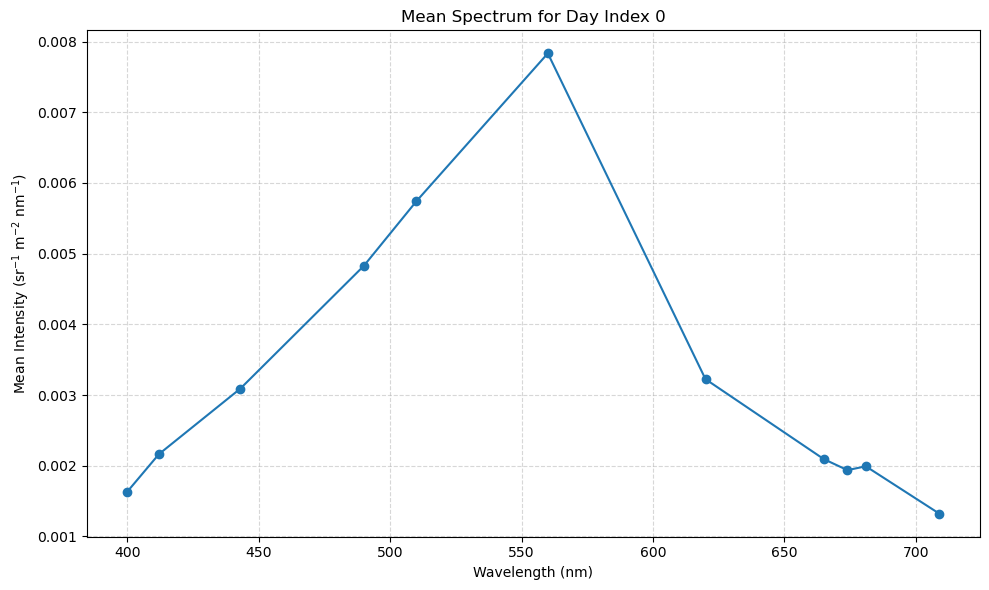

In [7]:
plot_day_spectrum(0)

## Post-processing
With this post-processing, we have access to all the Rrs data for all lon/lat bins (across a time window). However channel #21 is special (since it corresponds to chla). 

In [8]:
# Load data and metadata

data_path=npy_file
metadata_path=mdata_file

data = np.load(data_path)
print("data.shape:", data.shape)
with open(metadata_path, "rb") as f:
    metadata = pickle.load(f)
    
wavelengths = metadata["wavelengths"]
lat = metadata['lat']
lon = metadata['lon']


data.shape: (1, 93, 163, 22)


## Chlrophyll-a segmentation.
Since this reading has a large range from 0.1 to 1000, we we'll have to plot using log of the values.


/var/folders/1m/zm96cqs562qbmk_ptx3wwjy00000gn/T/ipykernel_48328/2908009633.py:25: RuntimeWarning: invalid value encountered in cast
  selected_after = selected.astype(np.uint8)   # Now values are 0 and 1


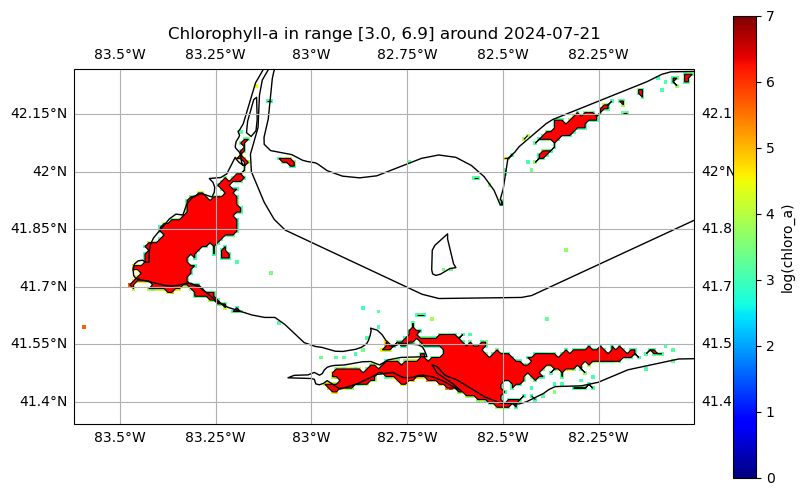

In [9]:
import cartopy as crs
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cv2
from matplotlib.patches import Polygon

min_thresh = 3.0
max_thresh = 6.9

# ---- Adjust colorbar limits ----
#plot = avw["avw"].plot(x="lon", y="lat", cmap="jet", vmin=450, vmax=575)

# Plot band 10 (zero-based indexing)
band_index = 21

# need to use log because of the spread of data
normd = np.log(data[0][:,:,band_index])

# Filter the higher value of chla
mask = (normd > min_thresh) & (normd < max_thresh) & np.isfinite(normd)  # True between thresholds

# Set elements where mask is False to NaN
selected = np.where(mask, normd, np.nan)

selected_after = selected.astype(np.uint8)   # Now values are 0 and 1  

# 4. Use OpenCV to find contours
contours, _ = cv2.findContours(selected_after, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# --- Plot on Cartopy ---
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# Set map extent to Lake Erie region
ax.set_extent([-83.62, -82.0, 41.34, 42.27], crs=ccrs.PlateCarree())
#ax.set_extent([-83.25, -82.5, 41.4, 41.6], crs=ccrs.PlateCarree())

# Add map features
ax.coastlines(resolution='10m')
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.LAKES, edgecolor='black', facecolor='none')
ax.gridlines(draw_labels=True)

# Plot reflectance
im = ax.pcolormesh(lon, lat, selected, cmap='jet', shading='auto', vmin=0, vmax=7, transform=ccrs.PlateCarree())

# Add colorbar and labels
cbar = plt.colorbar(im, ax=ax, orientation='vertical', label='log(chloro_a)')


# 5. Overlay contours back on map
for cnt in contours:
    # cnt is an array of shape (N, 1, 2) with (row, col) indices
    cnt = cnt.squeeze()  # shape (N, 2)
    if cnt.ndim != 2:
        continue  # skip if contour is malformed

    # Convert from array indices to lat/lon
    y_idx, x_idx = cnt[:, 1], cnt[:, 0]
    contour_lons = lon[x_idx]
    contour_lats = lat[y_idx]

    #ax.plot(contour_lons, contour_lats, color='red', linewidth=1.2, transform=ccrs.PlateCarree())
    poly = Polygon(
        np.column_stack((contour_lons, contour_lats)),
        closed=True,
        facecolor='red',
        edgecolor='black',
        linewidth=0.8,
        alpha=1.0,
        transform=ccrs.PlateCarree()
    )
    ax.add_patch(poly)

plt.title(f"Chlorophyll-a in range [{min_thresh}, {max_thresh}] around {start_date.date()}")
plt.show()


/Users/muthumayan/anaconda3/lib/python3.10/site-packages/matplotlib/axes/_axes.py:6762: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/Users/muthumayan/anaconda3/lib/python3.10/site-packages/matplotlib/axes/_axes.py:6763: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))


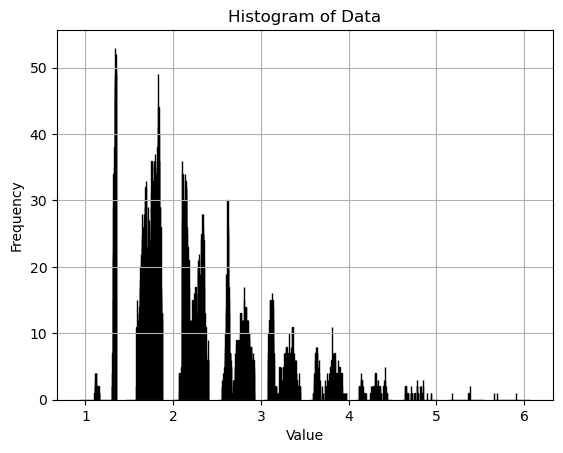

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Plot histogram

normd = data[0][:,:,band_index]
normd = np.log(normd)

plt.hist(normd, bins=10,  edgecolor='black')
plt.title('Histogram of Data')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()
